## Conditional VAE Example

This notebook demonstrates how to build a Conditional Variational Autoencoder (CVAE) [3]. We will train a CVAE to generate images of handwritten digits (0-9) given a label. Like VAE [1], CVAE will be built in CNN using PyTorch and trained on the MNIST dataset [2].

References:
- [1] Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes." arXiv preprint arXiv:1312.6114 (2013).
- [2] LeCun, Yann, and Corinna Cortes. "MNIST handwritten digit database." (2010).
- [3] Sohn, Kihyuk, Honglak Lee, and Xinchen Yan. "Learning structured output representation using deep conditional generative models." Advances in neural information processing systems. 2015.


In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

/home/rowel/anaconda3/envs/speech/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model Architecture

The CVAE is a generative model that learns a latent variable model for its input data. The main difference of CVAE from VAE is that CVAE learns a conditional distribution $p(x|y)$ instead of $p(x)$. 

In [2]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.proj = nn.Linear(10, 1*28*28)
        
    def forward(self, x, y):
        y = self.proj(y).reshape(-1, 1, 28, 28)
        x = torch.cat([x, y], dim=1)
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = x.flatten(1)
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dim=2):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 128*4*4)
        self.conv1 = nn.ConvTranspose2d(128*2, 64, kernel_size=3, stride=2, padding=1, output_padding=0)
        self.conv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.proj = nn.Linear(10, 128*4*4)
        
    def forward(self, x, y):
        y = self.proj(y).reshape(-1, 128, 4, 4)
        x = self.fc(x)
        x = x.view(-1, 128, 4, 4)
        x = torch.cat([x, y], dim=1)
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))
        return x
    

class CNN_VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(CNN_VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder(latent_dim=latent_dim)
        self.fc_mu = nn.Linear(128*4*4, latent_dim)
        self.fc_logvar = nn.Linear(128*4*4, latent_dim)
        
    def encode(self, x, y):
        x = self.encoder(x, y)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z, y):
        return self.decoder(z, y)
    
    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, y)
        return x_recon, mu, logvar
    


## Model Training

Like VAE, CVAE is trained on the MNIST dataset. The main difference is the use of label (a condition) for training:

```
label = label.to(device).long()  # Convert label to long type
label_one_hot = torch.nn.functional.one_hot(label, num_classes=10).float() 
```

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = CNN_VAE().to(device)

print(vae)
print(f"Number of model parameters: {sum(p.numel() for p in vae.parameters())/1e6:.2f} million")
print(f"Running on: {device}")

# Define the batch size for the dataloaders
batch_size = 128

# Load the MNIST train dataset
train_dataset = torchvision.datasets.MNIST(root='~/data', 
                                           train=True, 
                                           download=True, 
                                           transform=transforms.ToTensor())

# Create the train dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

# Load the MNIST test dataset
test_dataset = torchvision.datasets.MNIST(root='~/data', 
                                          train=False, 
                                          download=True, 
                                          transform=transforms.ToTensor())

# Create the test dataloader
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Set the number of epochs
num_epochs = 30

# Define the optimizer and the scheduler
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Set the model to training mode
vae.train()

acc_loss = []
kl_losses = []
recon_losses = []

# Train the model for the specified number of epochs
for epoch in range(num_epochs):
    acc_loss = []
    recon_losses = []
    kl_losses = []
    
    # Iterate over the training data
    for data in train_loader:
        # Get the input data
        img, label = data
        img = img.to(device)
        label = label.to(device).long()  # Convert label to long type
        label_one_hot = torch.nn.functional.one_hot(label, num_classes=10).float() 
    
        img_size = img.shape[-1] * img.shape[-2]
        batch_dim = img.shape[0]
        
        # Forward pass
        recon, mu, logvar = vae(img, label_one_hot)
        
        # Compute the reconstruction loss
        loss = nn.MSELoss()(recon, img)
        
        # Compute the KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Normalize to per pixel
        kl_loss /= (batch_dim * img_size)
 
        # Add the reconstruction loss and KL divergence loss
        total_loss = loss + kl_loss
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        acc_loss.append(total_loss.item())
        recon_losses.append(loss.item())
        kl_losses.append(kl_loss.item())
        
    scheduler.step()
    
    # Print the loss and current learning rate for each epoch
    print('Epoch [{}/{}], Recon Loss: {:.6f}, KL Loss: {:.6f}, LR: {:.6f}'.format(epoch+1, num_epochs, np.mean(recon_losses), np.mean(kl_losses), optimizer.param_groups[0]['lr']))


CNN_VAE(
  (encoder): Encoder(
    (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (proj): Linear(in_features=10, out_features=784, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=2, out_features=2048, bias=True)
    (conv1): ConvTranspose2d(256, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv3): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (proj): Linear(in_features=10, out_features=2048, bias=True)
  )
  (fc_mu): Linear(in_features=2048, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=2048, out_features=2, bias=True)
)
Number of model parameters: 0.30 million
Running on: cuda
Epoch [1/30

## Model Testing

The CVAE is tested on the MNIST test dataset. We can see that the generated images are fully controllable given the label.

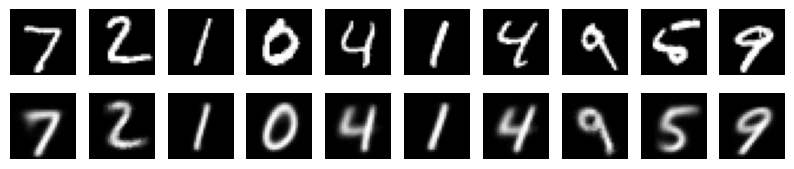

In [4]:
# Set the model to evaluation mode
vae.eval()

# Create empty lists to store the input images and decoded images
input_images = []
decoded_images = []

with torch.no_grad():
    # Iterate over the test dataloader
    for data in test_loader:
        # Get the input data
        img, label = data
        img = img.to(device)
        label = label.to(device).long()  # Convert label to long type
        label_one_hot = torch.nn.functional.one_hot(label, num_classes=10).float() 

        # Flatten the input data
        # inputs = inputs.view(inputs.size(0), -1)

        # Forward pass
        recon_batch, _, _ = vae(img, label_one_hot)
    
        # Append the input and decoded images to the lists
        input_images.append(img.detach().cpu().numpy())
        decoded_images.append(recon_batch.detach().cpu().numpy())

# Concatenate the input and decoded images
input_images = np.concatenate(input_images)
decoded_images = np.concatenate(decoded_images)

# Reshape the images
input_images = input_images.reshape(-1, 28, 28)
decoded_images = decoded_images.reshape(-1, 28, 28)

# Plot the input and decoded images
fig, axes = plt.subplots(2, 10, figsize=(10, 2))

for i in range(10):
    axes[0, i].imshow(input_images[i], cmap='gray')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(decoded_images[i], cmap='gray')
    axes[1, i].axis('off')

plt.show()


## Conditional Image Generation

We can also generate images of a specific label. For example, we can generate images of digits 0-9:


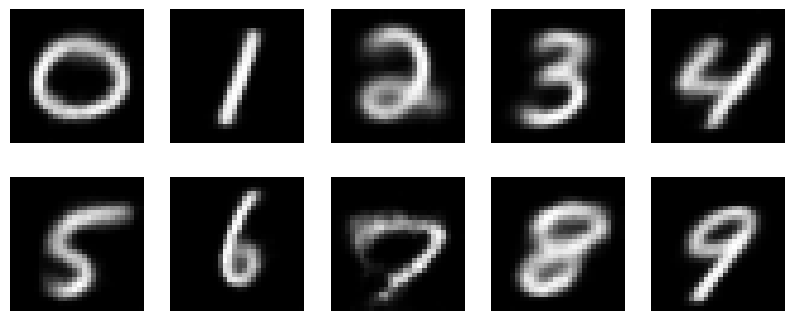

In [5]:
# Set the model to evaluation mode
vae.eval()

# Create empty list to store the generated images
generated_images = []

with torch.no_grad():
    # Iterate over the labels from 0 to 9
    for label in range(10):
        # Create a tensor for the label
        label_tensor = torch.tensor(label).unsqueeze(0).to(device)
        label_one_hot = torch.nn.functional.one_hot(label_tensor, num_classes=10).float()

        # Generate a random latent vector
        latent_vector = torch.randn(1, 2).to(device)

        # Decode the latent vector to generate an image
        generated_image = vae.decode(latent_vector, label_one_hot)

        # Append the generated image to the list
        generated_images.append(generated_image.detach().cpu().numpy())

# Concatenate the generated images
generated_images = np.concatenate(generated_images)

# Reshape the images
generated_images = generated_images.reshape(-1, 28, 28)

# Plot the generated images
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i in range(10):
    axes[i // 5, i % 5].imshow(generated_images[i], cmap='gray')
    axes[i // 5, i % 5].axis('off')

plt.show()
